### Process:
1. Use governance characteristics to cluster orgs.
1. Use cluster information from above to then predict Trustee or director salary

In [148]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
# plt.style.use('bmh')
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=[SettingWithCopyWarning, FutureWarning])


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn import linear_model

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import power_transform

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

## IMPORT DATA

In [8]:
# import executive compensation data
comp = pd.read_csv('02.data/executive_comp_data.csv')

# import governance data
# comp = pd.read_csv('02.data/xxx.csv')

In [9]:
comp.head()

,ein,period,title,trustee_or_director,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
0,10877614,201712,BOARD MEMBER/MANAGING D,True,55385.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
1,10877614,201712,BOARD MEMBER,True,60000.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
2,10884383,201712,PRESIDENT,True,71062.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
3,10884383,201712,VICE PRESIDENT,True,9010.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
4,10906593,201712,VP OF FINANC,True,87452.0,MANAGEMENT SERVICES INC,501(c)(3),S02,Management and technical assistance - Communit...,CA,2008.0,4161179,120847.0,881055.0,795668.0,S


In [10]:
# verify datatypes look as they should
comp.dtypes

ein                      int64
period                   int64
title                   object
trustee_or_director       bool
reportable_comp        float64
org_name                object
subsection              object
ntee_code               object
ntee_description        object
state                   object
formation_yr           float64
assets                   int64
liabilities            float64
expenses               float64
revenue                float64
ntee_letter             object
dtype: object

In [30]:
# fillna for formation_year
# I may want to do this with random forest instead
comp.formation_yr.fillna(comp.formation_yr.mean(), inplace=True)

In [32]:
pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

,formation_yr,assets,liabilities,expenses,revenue,subsection_501(c)(10),subsection_501(c)(12),subsection_501(c)(13),subsection_501(c)(14),subsection_501(c)(19),subsection_501(c)(3),subsection_501(c)(4),subsection_501(c)(5),subsection_501(c)(6),subsection_501(c)(7),subsection_501(c)(8),subsection_501(c)(9),subsection_Other,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,ntee_letter_A,ntee_letter_B,ntee_letter_C,ntee_letter_D,ntee_letter_E,ntee_letter_F,ntee_letter_G,ntee_letter_H,ntee_letter_I,ntee_letter_J,ntee_letter_K,ntee_letter_L,ntee_letter_M,ntee_letter_N,ntee_letter_O,ntee_letter_P,ntee_letter_Q,ntee_letter_R,ntee_letter_S,ntee_letter_T,ntee_letter_U,ntee_letter_V,ntee_letter_W,ntee_letter_X,ntee_letter_Y,ntee_letter_Z
0,2006.0,2112293,92283.0,500749.0,1792933.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2006.0,2112293,92283.0,500749.0,1792933.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007.0,97123,13093.0,1251188.0,1294636.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007.0,97123,13093.0,1251188.0,1294636.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2008.0,4161179,120847.0,881055.0,795668.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40092,1978.0,2754244,28296.0,359991.0,554329.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40093,1984.0,3187428,2977061.0,4465050.0,3679726.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40094,1981.0,327992,9503.0,473584.0,475958.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40095,1981.0,327992,9503.0,473584.0,475958.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [33]:
# assign X and y variables
y = comp.reportable_comp
X = pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

## Linear Regression Modeling

<a id="split_data"></a>

### Split data to be able to test the model on data it hasn't seen before

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

The number of observations in training set is 32077
The number of observations in test set is 8020


In [149]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        reportable_comp   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     86.80
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:02:38   Log-Likelihood:            -3.9201e+05
No. Observations:               32077   AIC:                         7.842e+05
Df Residuals:                   31981   BIC:                         7.850e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.537e+04    276.841    163.899      0.0

<a id="access_fit_predict"></a>

### Access fit and predict

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



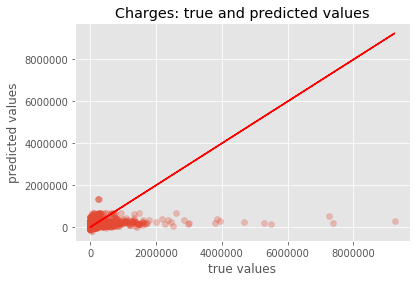

In [38]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()


Huge outliers are skewing the model.

<a id="linear"></a>
### Linear Regression with sklearn

In [41]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.08970151174889418
-----Test set statistics-----
R-squared of the model in the test set is: 0.09753413006180345
Mean absolute error of the prediction is: 84681.96918461511
Mean squared error of the prediction is: 63433530856.020424
Root mean squared error of the prediction is: 251860.14145954183
Mean absolute percentage error of the prediction is: 6559.082507499294


## Examine assumptions of linear regression

#### 2. the error term should be zero on average


In [65]:
lrm.fit(X, y)
predictions = lrm.predict(X)
errors = y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -4.041452676836004e-11


Since I have included the constant term in the model, the average of the model's error is effectively zero.

#### 3. homoscedasticity - the distribution of its error terms (known as "scedasticity") is consistent for all predicted values

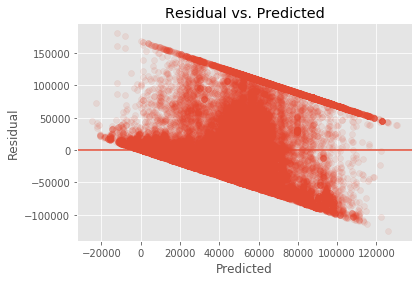

In [66]:
plt.scatter(predictions, errors, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Visually, it appears to not be homoscedastic.

In [67]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 15938.4 and p value is 0
Levene test statistic value is 7635.08 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

<font color=red> Some fixes to heteroscedasticity include transforming the dependent variable (see [Box Cox transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) and [log transformation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/)) and adding features that target the poorly-estimated areas.</font>

#### 4. low multicollinearity

(97.0, 0.0)

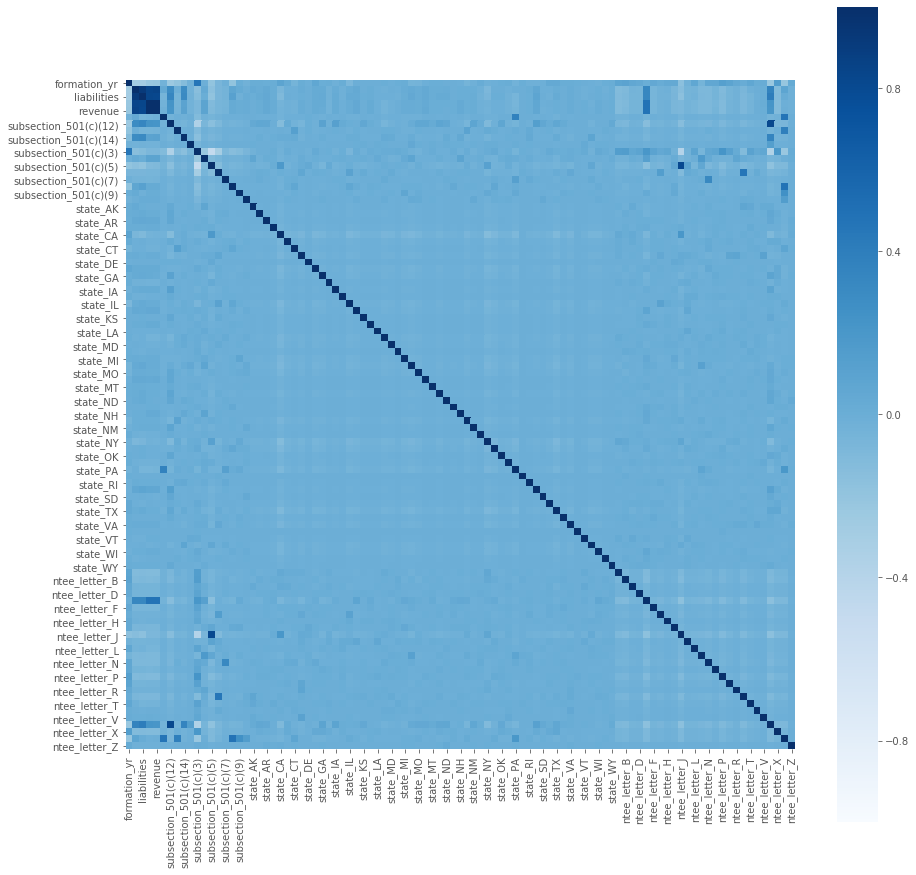

In [70]:
# compare features using a heatmap
plt.figure(figsize=(15, 15))

ax = sns.heatmap(X.corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

It doesn't seem that many of them are very correlated, especially not neighborhoods.

#### 5. error terms should be uncorrelated with one another


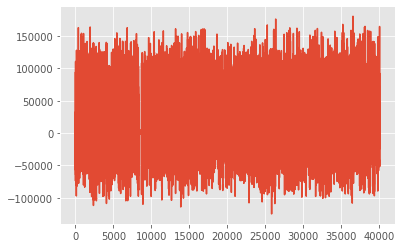

In [71]:
plt.plot(errors)

#### 6. features shouldn't be correlated with the errors


Arguably the most important assumption: explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the **exogeneity**.

Violations of the exogeneity assumption may have several sources. Common causes are omitted variables and simultaneous causation between independent variables and the target. If the problem stems from simultaneous causation then we need to apply some advanced techniques to solve for the issue but this is beyond the scope of this bootcamp.

#### 7. normality of the errors

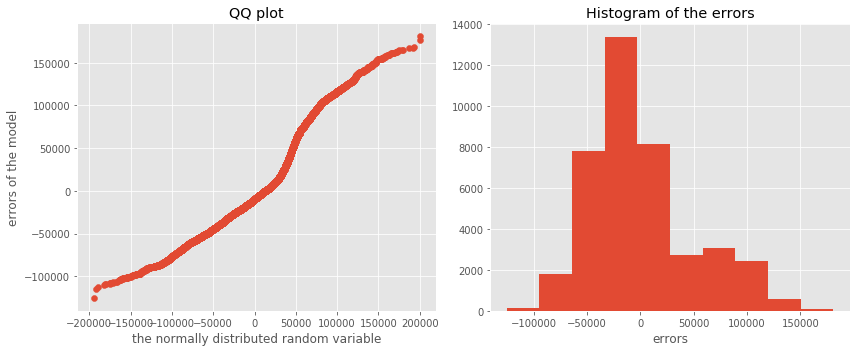

In [73]:
# check for the normality of the errors
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()

The errors seems to be roughly normal, but not perfectly normal through visual inspection.

In [74]:
# check for normality using statistical tests

from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 4879.603431954727 and p value is 0.0
Normality test statistics is 3742.8224041490826 and p value is 0.0


The super small p-value result from each of these tests indicate that my errors are not normally distributed.

<a id="elastic"></a>
### ElasticNet Regression

In [108]:
# assign X and y variables
y = comp.reportable_comp
X = pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [107]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [117]:
scaler = StandardScaler()


In [119]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [120]:
X_trans = scaler.transform(X)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = 0.2, random_state = 42)

In [147]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5, max_iter=3000)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30738269712426.293, tolerance: 7813320277.594606

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30936828507175.953, tolerance: 7813320277.594606

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30930903640350.44, tolerance: 7813320277.594606

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30930345024576.723, tol

Best alpha value is: 1e-06
R-squared of the model in training set is: 0.20505392516109822
-----Test set statistics-----
R-squared of the model in test set is: 0.21385814412382484
Mean absolute error of the prediction is: 37764.75598698567
Mean squared error of the prediction is: 2424135145.216482
Root mean squared error of the prediction is: 49235.50695602191
Mean absolute percentage error of the prediction is: 4662.967457268848


C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 38688090350368.2, tolerance: 9733493359.57815



## Random Forrest Regressor Model

In [75]:
# assign X and y variables
y = comp.reportable_comp
X = pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [79]:
rfr = ensemble.RandomForestRegressor()

cross_val_score(rfr, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



array([0.14170152, 0.04007892, 0.20613522, 0.04194443, 0.13247402])

It definitely seems to be overfitting in some iterations.

In [85]:
rfr = rfr.fit(X, y)
rfr.feature_importances_

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



array([9.21117790e-02, 1.13969618e-01, 8.76144102e-02, 2.11634932e-01,
       1.15411031e-01, 4.42166971e-04, 9.68328330e-04, 9.50819949e-04,
       9.22504995e-04, 1.78871848e-04, 1.06081634e-01, 3.00158771e-03,
       3.08944664e-03, 2.68063364e-02, 4.88124474e-04, 1.45900670e-04,
       1.46777353e-04, 2.45403065e-04, 1.67105712e-03, 1.16872737e-03,
       9.67887415e-04, 1.72682758e-03, 1.05852783e-02, 2.84117312e-03,
       1.11012247e-03, 1.60297359e-02, 3.29586716e-04, 5.30002080e-03,
       2.68199011e-03, 5.65634062e-04, 1.48652915e-03, 3.31485856e-04,
       3.96913793e-03, 5.90992775e-03, 1.12389089e-03, 2.51353155e-03,
       1.35629461e-03, 4.39172925e-03, 4.76277500e-03, 4.58772636e-04,
       2.76169619e-03, 6.73424636e-03, 2.67719933e-03, 8.45229524e-04,
       7.29530044e-04, 1.42905825e-03, 3.85511813e-04, 6.62449427e-04,
       5.16198175e-04, 6.28489786e-03, 3.76195427e-04, 6.90805882e-04,
       1.48154367e-02, 7.80525041e-03, 1.49749021e-03, 1.66534362e-03,
      

In [86]:
f_importances = pd.DataFrame(rfr.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

In [89]:
f_importances.head(30)*100

,importance
expenses,21.163493
revenue,11.541103
assets,11.396962
subsection_501(c)(3),10.608163
formation_yr,9.211178
liabilities,8.761441
subsection_501(c)(6),2.680634
state_DC,1.602974
state_NY,1.481544
state_CA,1.058528


## Support Vector Regressor

In [213]:
# assign X and y variables
y = comp.reportable_comp
X = pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [214]:
scaler = StandardScaler()

In [216]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)

# must convert to array and reshape
# otherwise error message
y = sc_y.fit_transform(np.array(y).reshape(-1, 1))

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [226]:
pd.DataFrame(X_test).shape

(8020, 97)

In [228]:
pd.DataFrame(y_test).shape

(8020, 1)

In [218]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')

In [223]:
svr.fit(X_train, y_train)

TypeError: issubclass() arg 2 must be a class or tuple of classes

In [ ]:
cross_val_score(svr, X, Y, cv=5)

## SPARE PARTS

## Linear Regression - Outliers Removed

In [42]:
# assign X and y variables
y = comp.reportable_comp
X = pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [44]:
X.iloc[:,0:5]

,formation_yr,assets,liabilities,expenses,revenue
0,2006.0,2112293,92283.0,500749.0,1792933.0
1,2006.0,2112293,92283.0,500749.0,1792933.0
2,2007.0,97123,13093.0,1251188.0,1294636.0
3,2007.0,97123,13093.0,1251188.0,1294636.0
4,2008.0,4161179,120847.0,881055.0,795668.0
...,...,...,...,...,...
40092,1978.0,2754244,28296.0,359991.0,554329.0
40093,1984.0,3187428,2977061.0,4465050.0,3679726.0
40094,1981.0,327992,9503.0,473584.0,475958.0
40095,1981.0,327992,9503.0,473584.0,475958.0


In [45]:
# trim at 90th percentile
for column in X.iloc[:,0:5]:
    X[column].clip(upper=X[column].quantile(.9), inplace=True)

y.clip(upper=y.quantile(.9), inplace=True)

<a id="split_data"></a>

### Split data to be able to test the model on data it hasn't seen before

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [56]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



                            OLS Regression Results                            
Dep. Variable:        reportable_comp   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     90.09
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:08:21   Log-Likelihood:            -3.9189e+05
No. Observations:               32077   AIC:                         7.840e+05
Df Residuals:                   31981   BIC:                         7.848e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.22e+

<a id="access_fit_predict"></a>

### Access fit and predict

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



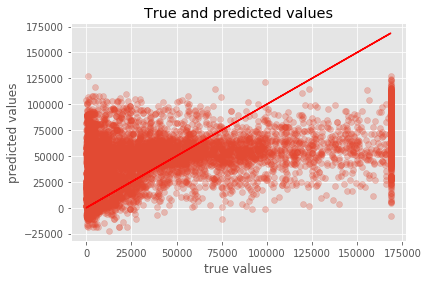

In [59]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()


<a id="linear"></a>
### Linear Regression with sklearn

In [58]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.21111563121754984
-----Test set statistics-----
R-squared of the model in the test set is: 0.22083257930024625
Mean absolute error of the prediction is: 37673.80045847963
Mean squared error of the prediction is: 2402695462.9157667
Root mean squared error of the prediction is: 49017.297588869245
Mean absolute percentage error of the prediction is: 4578.8361807000765


## Linear Regression - Outliers Removed Features transformed with Box-Cox

In [91]:
# assign X and y variables
y = comp.reportable_comp
X = pd.get_dummies(comp[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [92]:
# trim at 90th percentile
for column in X.iloc[:,0:5]:
    X[column].clip(upper=X[column].quantile(.9), inplace=True)

y.clip(upper=y.quantile(.9), inplace=True)

In [93]:
power_transform(X, method='box-cox')

ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [96]:
X = X.transform(np.sqrt)

In [97]:
y = y.transform(np.sqrt)

<a id="split_data"></a>

### Split data to be able to test the model on data it hasn't seen before

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

ValueError: Found input variables with inconsistent numbers of samples: [39975, 40097]

In [100]:
X.isna().sum()

formation_yr      0
assets           20
liabilities      60
expenses          0
revenue          45
                 ..
ntee_letter_V     0
ntee_letter_W     0
ntee_letter_X     0
ntee_letter_Y     0
ntee_letter_Z     0
Length: 97, dtype: int64

In [104]:
# drop na values
X.dropna(how='any', axis='rows', inplace=True)

In [105]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



MissingDataError: exog contains inf or nans

<a id="access_fit_predict"></a>

### Access fit and predict

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



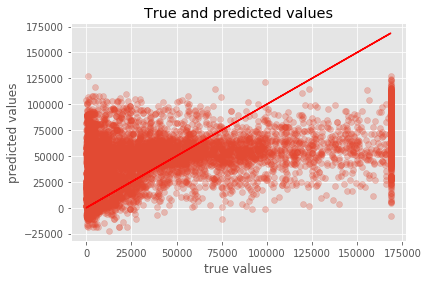

In [59]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()


<a id="linear"></a>
### Linear Regression with sklearn

In [58]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.21111563121754984
-----Test set statistics-----
R-squared of the model in the test set is: 0.22083257930024625
Mean absolute error of the prediction is: 37673.80045847963
Mean squared error of the prediction is: 2402695462.9157667
Root mean squared error of the prediction is: 49017.297588869245
Mean absolute percentage error of the prediction is: 4578.8361807000765
